In [83]:
from dotenv import load_dotenv
import os

load_dotenv()

os.environ["GOOGLE_API_KEY"]=os.getenv("GEMINI_API_KEY")
os.environ["HUGGINGFACE_HUB_TOKEN"]=os.getenv("HUGGINGFACE_HUB_TOKEN")
## Langsmith Tracking And Tracing
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"]=os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"]="true"

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

# Load Model

In [84]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.embeddings import HuggingFaceEmbeddings
# Create embeddings for the text chunks
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
model=ChatGoogleGenerativeAI(model='gemini-1.5-flash')
output=model.invoke("hi")
print(output.content)

Hi there! How can I help you today?


In [85]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS


faiss_index="vectordb_faiss_index"  # Directory to save the FAISS index
def load_vector_store():
    # Load the PDF file
    pdf_path = "pdfs/document.pdf"
    loader = PyPDFLoader(pdf_path)
    documents = loader.load()

    # Split the documents into smaller chunks
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    split_docs = text_splitter.split_documents(documents)
    print(f"Number of chunks created: {len(split_docs)}")
    # Print the first chunk for verification   
    print(f"First chunk: {split_docs[0].page_content[:500]}...")
    # Create a FAISS vector store from the embeddings
    vector_store = FAISS.from_documents(split_docs, embeddings)

    # Save the vector store to disk
    vector_store.save_local(faiss_index)
    print("Vector store created and saved successfully.")
if __name__ == "__main__":
    load_vector_store()
# Ensure you have the required libraries installed:
# pip install langchain-community faiss-cpu sentence-transformers   
# Make sure to replace "path/to/your/document.pdf" with the actual path to your PDF file.
# You can also adjust the chunk size and overlap as needed.

Number of chunks created: 314
First chunk: Andrew Ng 
Andrew Ng  
Deep Learning 
Thanks to Adam Coates, Kai Yu, Tong Zhang, Sameep Tandon, 
Swati Dube, Brody Huval, Tao Wang, …....
Vector store created and saved successfully.


In [86]:
def get_retriever():
    # Load the vector store from disk
    if not os.path.exists(faiss_index):
        print(f"Vector store directory '{faiss_index}' does not exist. Please run the load_vector_store function first.")
        return None
    vector_store=FAISS.load_local(faiss_index, embeddings, allow_dangerous_deserialization=True)
    retriever=vector_store.as_retriever(search_kwargs={"k": 3})
    return retriever

In [87]:
# Function to get an answer from the vector store based on a query
def get_answer(query):
    # Load the vector store
    retriever = get_retriever()
    if retriever is None:
        print("Retriever could not be created. Exiting.")
        return []
    # Query the vector store
    results = retriever.invoke(query)  # Adjust k for the number of results you want
    if not results:
        print("No results found for the query.")
        return []
    results_texts = [doc.page_content for doc in results]
    return results_texts


answer=get_answer("What is the main topic of the document?")
print("Answer to the query:")
for i, text in enumerate(answer):
    print(f"{i+1}: {text}")
    break  # Remove this break to see all results, currently it will only print the first result
# Note: The above code assumes you have a PDF document at "pdfs/document.pdf".   

Answer to the query:
1: 3 Prerequisites and Notation 
 
If you have taken a Machine Learning course such as my machine learning MOOC on 
Coursera, or if you have experience applying supervised learning, you will be able to 
understand this text.  
I assume you are familiar with ​supervised learning​: learning a function that maps from x 
to y, using labeled training examples (x,y). Supervised learning algorithms include linear 
regression, logistic regression, and neural networks. There are many forms of machine 
learning, but the majority of Machine Learning’s practical value today comes from 
supervised learning.  
I will frequently refer to neural networks (also known as “deep learning”). You’ll only need a 
basic understanding of what they are to follow this text.  
If you are not familiar with the concepts mentioned here, watch the first three weeks of 
videos in the Machine Learning course on Coursera at ​http://ml-class.org 
  
Page 9 Machine Learning Yearning-Draft Andrew Ng


# state class

In [107]:
from typing import Sequence, Annotated
import operator
from langchain_core.messages import BaseMessage
# Instead, define your own AgentState:
from typing import TypedDict, List

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

# pydentic setup

In [89]:
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser

class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="selected topic")
    Reasoning:str=Field(description='Reasoning behind topic selection')

parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)

# RAG Setup

In [100]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Function to format the retrieved documents
def format_docs(docs):
    return "\n\n".join([doc.page_content for doc in docs])

# RAG Function
def rag_function(state:AgentState):
    print("-> RAG Call ->")
    
    question = state["messages"][0]
    
    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )
    retriever = get_retriever()
    if retriever is None:
        return {"messages": ["Retriever could not be created."]}
        
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return  {"messages": [result]}

In [102]:
res=rag_function(AgentState({"messages": ["What is the main topic of the document?"]}))
# Note: The above code assumes you have a PDF document at "pdfs/document.pdf".
res = res["messages"][0]
print("RAG Result:")
print(res)

-> RAG Call ->
RAG Result:
The document focuses on prerequisites and notation for understanding machine learning, specifically supervised learning and neural networks.  It assumes some familiarity with machine learning concepts but provides resources for those lacking it.  The excerpt also includes a brief section on text features.


# LLM

In [92]:
def classify_query(state: AgentState):
    question = state["messages"][-1]
    print("Question:", question)
    
    template = """
    You are a classifier that categorizes user queries into one of the following three categories:
    - deep learning: if the question is about deep learning, neural networks, AI models, etc.
    - news: if the question is about recent events, current affairs, trends, or real-world updates.
    - Not Related: if the question is unrelated to deep learning or news.

    Only respond with one of the following exact words: deep learning, news, Not Related.

    User query: {question}
    {format_instructions}
    """
    
    prompt = PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
    
    chain = prompt | model | parser
    response = chain.invoke({"question": question})
    print("Parsed response:", response)
    return {"messages": [response.Topic]}


In [101]:
state={"messages":["please provide today news  delhi?"]}
classify_query(state)

Question: please provide today news  delhi?
Parsed response: Topic='news' Reasoning='The query explicitly asks for news about Delhi.'


{'messages': ['news']}

In [158]:
from langchain_community.tools import TavilySearchResults   
tavily_search = TavilySearchResults()    

def fetch_realtime_info_tavily(state:AgentState):
    print("-> Realtime Info Call ->")
    
    question = state["messages"][0]
    
    # Use the Tavily search tool to get real-time information
    results = tavily_search.invoke(question)
    # print("Search results:", results)
    if not results:
        return {"messages": ["No real-time information found."]}
    
    # Format the results into a string
    formatted_results = "\n\n".join([result['content'] for result in results])
    print("Formatted results:", formatted_results)
    return {"messages": [formatted_results]}

In [95]:
state={"messages":["what is latest news in AI?"]}
fetch_realtime_info_tavily(state)

-> Realtime Info Call ->
Search results: [{'title': 'Latest AI Breakthroughs and News: May-June 2025 - Crescendo.ai', 'url': 'https://www.crescendo.ai/news/latest-ai-news-and-updates', 'content': '**Date:** June 1, 2025  \n**Summary:** Ukraine reportedly used AI-enhanced drone swarms in a covert mission dubbed â\x80\x9cOperation Spider Webâ\x80\x9d to target a Russian bomber. The drones, said to cost as little as the price of an iPhone 16 Pro, represent a new phase of low-cost autonomous warfare. [...] **Date:** May 30, 2025  \n**Summary:** Nvidia CEO Jensen Huang issued a bold warning about the rapid evolution of AI, emphasizing that people who fail to adopt AI in their workflow risk being replaced by those who do. His comments underline the urgency for upskilling in a transforming job market. [...] **Date:** May 31, 2025  \n**Summary:** Monash University has announced a landmark investment in an AI supercomputer, becoming the first higher education institute in Australia to do so. Th

{'messages': ['**Date:** June 1, 2025  \n**Summary:** Ukraine reportedly used AI-enhanced drone swarms in a covert mission dubbed â\x80\x9cOperation Spider Webâ\x80\x9d to target a Russian bomber. The drones, said to cost as little as the price of an iPhone 16 Pro, represent a new phase of low-cost autonomous warfare. [...] **Date:** May 30, 2025  \n**Summary:** Nvidia CEO Jensen Huang issued a bold warning about the rapid evolution of AI, emphasizing that people who fail to adopt AI in their workflow risk being replaced by those who do. His comments underline the urgency for upskilling in a transforming job market. [...] **Date:** May 31, 2025  \n**Summary:** Monash University has announced a landmark investment in an AI supercomputer, becoming the first higher education institute in Australia to do so. The system will significantly accelerate national research across AI, medicine, and engineering fields.']}

In [110]:
# LLM Function
def get_llm_response(state:AgentState):
    print("-> LLM Call ->")
    question = state["messages"][0]
    
    # Normal LLM call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = model.invoke(complete_query)
    return {"messages": [response.content]}

# Router

In [ ]:
def router(state:AgentState):
    print("-> ROUTER ->")
    
    last_message=state["messages"][-1]
    print("last_message:", last_message)
    if "deep learning" in last_message.lower():
        return "RAG Call"
    elif "news" in last_message.lower():
        return "Realtime Info Call"
    else: 
        return "LLM Call"

# Validation

In [152]:
# Validation Node Function
def validate_output(state: AgentState):
    print("-> VALIDATION NODE ->")
    last_message = state["messages"][-1]
    # Simple validation: check if the output is not empty and not a default fallback
    if not last_message or "could not be created" in last_message.lower() or "don't know" in last_message.lower():
        print("Validation failed.")
        return {"valid": False, "messages": state["messages"]}
    print("Validation passed.")
    return {"valid": True, "messages": state["messages"]}

# Conditional edge from Validation node
def validation_router(state):
    if state.get("valid"):
        return "END"
    else:
        return "Supervisor"

# Langgraph setup

In [159]:
from langgraph.graph import StateGraph,END

# Define the state graph
workflow=StateGraph(AgentState)
workflow.add_node("Supervisor",classify_query)
workflow.add_node("RAG", rag_function)
workflow.add_node("Realtime", fetch_realtime_info_tavily)
workflow.add_node("LLM", get_llm_response)
workflow.add_node("Validation", validate_output)


#workflow.add_node("END", END)

# workflow entrypoint
workflow.set_entry_point("Supervisor")

# worflow conditionl edge

workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
        "Realtime Info Call": "Realtime"
    }
)


# workflow.add_edge("RAG",END)
# workflow.add_edge("LLM",END)
#app=workflow.compile()
# Add edges from RAG, LLM, and Realtime nodes to Validation node
workflow.add_edge("RAG", "Validation")
workflow.add_edge("LLM", "Validation")
workflow.add_edge("Realtime", "Validation")

workflow.add_conditional_edges(
    "Validation",
    validation_router,
    {
        "END": END,
        "Supervisor": "Supervisor"
    }
)

# Re-compile the workflow to apply changes
app = workflow.compile()

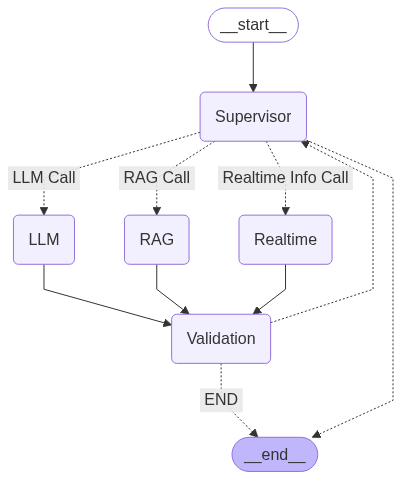

In [160]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [161]:
app.invoke(AgentState({"messages": ["What is the latest news in Delhi?"]}))
# app.invoke(AgentState({"messages": ["What is the latest news in AI?"]}))
# app.invoke(AgentState({"messages": ["What is the deep learning?"]}))
# app.invoke(AgentState({"messages": ["What is the main topic of the document?"]}))   

Question: What is the latest news in Delhi?
Parsed response: Topic='news' Reasoning='The query explicitly asks for the latest news in Delhi.'
-> ROUTER ->
last_message: news
-> Realtime Info Call ->
Formatted results: ![Rekha Gupta](https://static.indiatvnews.com/ins-web/images/lazy.webp)

### Official residence of Delhi chief minister Rekha Gupta allotted at Civil Lines

## LATEST DELHI NEWS

### Delhi: Fire breaks out at e-rickshaw charging station in Ghonda area

![Delhi Fire, fire at e-rickshaw charging station in Ghonda area, fire tenders on spot, delhi fire res](https://static.indiatvnews.com/ins-web/images/lazy-small.webp)

### Delhi CM Rekha Gupta receives death threat, police probe underway [...] ### A cautious cheers: Delhi microbreweries ordered to send beer samples for testing before serving

![Delhi excise department issues new rules for microbreweries](https://static.indiatvnews.com/ins-web/images/lazy-small.webp)

### Manish Sisodia, Satyendar Jain summoned by ACB in all

{'messages': ['What is the latest news in Delhi?',
  'news',
  "![Rekha Gupta](https://static.indiatvnews.com/ins-web/images/lazy.webp)\n\n### Official residence of Delhi chief minister Rekha Gupta allotted at Civil Lines\n\n## LATEST DELHI NEWS\n\n### Delhi: Fire breaks out at e-rickshaw charging station in Ghonda area\n\n![Delhi Fire, fire at e-rickshaw charging station in Ghonda area, fire tenders on spot, delhi fire res](https://static.indiatvnews.com/ins-web/images/lazy-small.webp)\n\n### Delhi CM Rekha Gupta receives death threat, police probe underway [...] ### A cautious cheers: Delhi microbreweries ordered to send beer samples for testing before serving\n\n![Delhi excise department issues new rules for microbreweries](https://static.indiatvnews.com/ins-web/images/lazy-small.webp)\n\n### Manish Sisodia, Satyendar Jain summoned by ACB in alleged Rs 2,00 crore classroom construction scam\n\n![Sisodia and Jain have been asked to appear before the ACB](https://static.indiatvnews.co

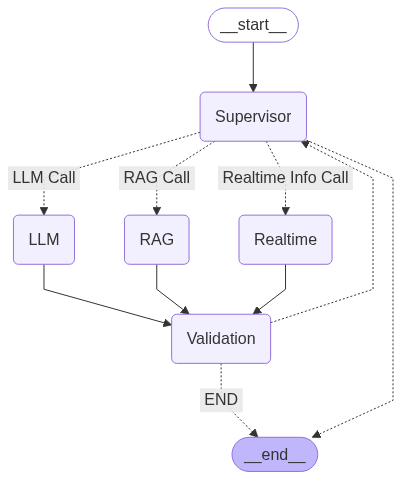

In [146]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))